In [1]:
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm

# MSE imports
import kepler_sieve
from asteroid_element import load_ast_elt
from ztf_ast import calc_hit_freq
from ztf_data import load_ztf_det_all, load_ztf_nearest_ast
from ztf_element import load_ztf_batch
from candidate_element import asteroid_elts
from astro_utils import deg2dist, dist2deg

In [2]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load Asteroid Data

In [4]:
ast_elt = load_ast_elt()

In [5]:
ast_elt

,Num,Name,epoch,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri,row_num
Num,,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873,0
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804,1
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558,2
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421,3
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,58600.0,0.822197,0.237862,0.220677,5.066979,3.770460,0.503214,21.55,0.15,JPL 1,0.807024,272.309165,0.023074,-3.225717,-2.921908,-3.728932,-21.808984,733484
1255501,1255501,2019 QL,58600.0,2.722045,0.530676,0.113833,4.741919,2.351059,5.297173,19.21,0.15,JPL 1,-2.082964,1640.368337,0.003830,-0.176219,-1.273172,0.809793,257.420824,733485
1255502,1255502,2019 QQ,58600.0,1.053137,0.389091,0.172121,5.648270,2.028352,3.266522,25.31,0.15,JPL 1,-3.081905,394.753268,0.015917,-1.623227,-1.688469,1.393436,189.527723,733486


In [7]:
H = ast_elt['H']
np.mean(H)

16.60518006405059

In [8]:
np.max(H)

99.0

In [9]:
ztf, mjd_unq = load_ztf_det_all()

In [10]:
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504
...,...,...,...,...,...,...,...,...,...,...,...
5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023
5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474
5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662
5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241


In [11]:
ztf_ast = load_ztf_nearest_ast()

In [12]:
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976
1,1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393
2,2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691
3,3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181
4,4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697957,5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246
5697958,5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382
5697959,5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200
5697960,5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274


## Load Computed Positions of Elements for Asteroids with Most Hits

In [13]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [14]:
batch_size = 64

# Batch of unperturbed elements
elts = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

# Add hit_count column
elts['hit_count'] = hit_count_best[0:batch_size]

elts

,element_id,a,e,inc,Omega,omega,f,epoch,hit_count
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,194
1,59244,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0,190
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,189
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0,188
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,186
...,...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,148
60,134815,2.612770,0.140831,0.513922,0.272689,0.645552,-0.957836,58600.0,148
61,27860,2.619406,0.096185,0.200633,5.541400,3.266046,3.948770,58600.0,148
62,85937,2.342291,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,148


In [15]:
# Load unperturbed element batch
ztf_elt_ast = load_ztf_batch(elts=elts, thresh_deg=2.0, near_ast=True)

In [16]:
ztf_elt_ast

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,-0.057300,-0.982042,0.179751,2.234078,0.010624,2191.408734,0.999944,0.092645,False,False
1,73603,733,b'ZTF18ablwzmb',609167834815015007,7226,58363.167836,265.761064,-13.509195,18.339701,-0.071871,...,-0.055041,-0.979702,0.192757,2.397172,0.027352,5641.954857,0.999626,0.614061,False,False
2,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,-0.057300,-0.982042,0.179751,2.234078,0.016809,3467.151428,0.999859,0.231907,False,False
3,73605,733,b'ZTF18ablwzmb',584189894815015004,4646,58338.189896,265.761079,-13.509107,16.892200,-0.071871,...,-0.045072,-0.984663,0.168544,2.138928,0.027030,5575.548058,0.999635,0.599691,False,False
4,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.000919,-0.977996,0.208622,2.703478,0.005450,1124.103915,0.999985,0.024378,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322909,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,0.627608,0.750726,0.206199,2.981918,0.025126,5182.803024,0.999684,0.518186,False,False
322910,5651378,324582,b'ZTF20aaqvkyo',1150185754815015007,96635,58904.185752,42.122572,29.195466,18.337299,0.647485,...,0.627608,0.750726,0.206199,2.981918,0.029094,6001.222051,0.999577,0.694749,False,False
322911,5651434,324582,b'ZTF20aaqvkus',1150185310315015002,96634,58904.185313,43.256211,29.954124,19.257601,0.631015,...,0.627610,0.750725,0.206200,2.981912,0.017707,3652.453216,0.999843,0.257358,False,False
322912,5651513,324582,b'ZTF20aaqvlna',1150185755115015011,96635,58904.185752,42.388038,28.228923,19.199400,0.650751,...,0.627608,0.750726,0.206199,2.981918,0.030306,6251.306560,0.999541,0.753854,False,False


In [17]:
ztf_elt_ast.columns

Index(['ztf_id', 'element_id', 'ObjectID', 'CandidateID', 'TimeStampID', 'mjd',
       'ra', 'dec', 'mag_app', 'ux', 'uy', 'uz', 'nearest_ast_num',
       'nearest_ast_dist', 'ast_ra', 'ast_dec', 'ast_ux', 'ast_uy', 'ast_uz',
       'qx', 'qy', 'qz', 'vx', 'vy', 'vz', 'elt_ux', 'elt_uy', 'elt_uz',
       'elt_r', 's', 's_sec', 'z', 'v', 'is_hit', 'is_match'],
      dtype='object')

## Add computed Columns; Follow Naming Scheme in AsteroidSearch

In [18]:
mask = ztf_elt_ast.is_hit
ztf_hit = ztf_elt_ast[mask]

# Distance from earth to asteroid
ztf_hit['delta'] = ztf_hit['elt_r']
ztf_hit.drop(columns='elt_r')
ztf_hit['delta_x'] = ztf_hit.delta * ztf_hit.ux
ztf_hit['delta_y'] = ztf_hit.delta * ztf_hit.uy
ztf_hit['delta_z'] = ztf_hit.delta * ztf_hit.uz
ztf_hit['earth_x'] = ztf_hit.qx- ztf_hit.delta_x
ztf_hit['earth_y'] = ztf_hit.qy- ztf_hit.delta_y
ztf_hit['earth_z'] = ztf_hit.qz- ztf_hit.delta_z
ztf_hit['H'] = ast_elt.loc[ztf_hit.element_id].H.values
ztf_hit['G'] = ast_elt.loc[ztf_hit.element_id].G.values

In [19]:
# Extract arrays
H = ztf_hit['H']
G = ztf_hit['G']
q_ast  = ztf_hit[['qx', 'qy', 'qz']].values
q_obs = ztf_hit[['earth_x', 'earth_y', 'earth_z']].values

# Distance from sun to asteroid
ztf_hit['r'] = np.linalg.norm(q_ast, axis=-1)

# Distances
r = ztf_hit.r.values
delta = ztf_hit.delta.values

In [20]:
# Distance adjustment
dist_adj = 5.0 * np.log10(ztf_hit.delta * ztf_hit.r)

# Calculated phase angle
dot_product = np.sum(q_obs*q_ast, axis=1)
denom = np.linalg.norm(q_obs, axis=-1) * ztf_hit.r
cos_alpha = dot_product / denom
alpha = np.arccos(cos_alpha)
alpha_deg = np.rad2deg(alpha)

In [21]:
# Phase angle
ztf_hit['alpha'] = alpha
# Limit alpha to 20 degrees for phase correction
alpha_max = np.deg2rad(30.0)
alpha_phase = np.minimum(alpha, alpha_max)

# Phase adjustment
A1 = 3.33
A2 = 1.87
B1 = 0.63
B2 = 1.22
tan_half_alpha = np.tan(0.5 * alpha_phase)
phi_1 = np.exp(-A1 * tan_half_alpha**B1)
phi_2 = np.exp(-A2 * tan_half_alpha**B2)
phase_adj_sum = (1.0-G)*phi_1 + G*phi_2
phase_adj = 2.5*np.log10(phase_adj_sum)

In [22]:
# Calculated V; experiment with modulating phase adjustment
V = H + dist_adj - phase_adj
ztf_hit['dist_adj'] = dist_adj
ztf_hit['phase_adj'] = phase_adj
ztf_hit['V_calc'] = V
ztf_hit['V_obs'] = ztf_hit['mag_app']

In [23]:
cols = ['ztf_id', 'element_id', 'qx', 'qy', 'qz', 'r', 'earth_x', 'earth_y', 'earth_z', 'delta', 'alpha', 'H','G', 'dist_adj', 'phase_adj', 'V_calc', 'V_obs']
ztf_hit[cols]

,ztf_id,element_id,qx,qy,qz,r,earth_x,earth_y,earth_z,delta,alpha,H,G,dist_adj,phase_adj,V_calc,V_obs
30,341737,733,1.846146,0.512673,1.005240,2.163700,0.563282,-0.835704,2.312495e-05,2.115260,1.286567,9.05,0.15,3.302803,-1.300067,13.652871,17.784599
33,345725,733,1.845997,0.513148,1.005156,2.163646,0.563838,-0.835319,1.993403e-05,2.114851,1.286204,9.05,0.15,3.302331,-1.300067,13.652398,18.220100
36,346522,733,1.845992,0.513164,1.005153,2.163645,0.563857,-0.835306,2.010042e-05,2.114837,1.286191,9.05,0.15,3.302314,-1.300067,13.652382,18.129601
40,347644,733,1.846242,0.512367,1.005295,2.163734,0.562922,-0.835952,2.595450e-05,2.115523,1.286801,9.05,0.15,3.303108,-1.300067,13.653176,17.705700
47,431445,733,1.857095,0.476847,1.011449,2.167767,0.520868,-0.862977,2.455613e-05,2.145603,1.313600,9.05,0.15,3.337810,-1.300067,13.687877,17.974701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322817,5447574,324582,1.013468,2.631989,0.622579,2.888267,-0.866068,0.491963,6.871892e-07,2.915471,1.425295,15.80,0.15,4.626730,-1.300067,21.726797,18.231701
322830,5450145,324582,1.013464,2.631990,0.622578,2.888267,-0.866072,0.491955,4.407670e-07,2.915477,1.425301,15.80,0.15,4.626735,-1.300067,21.726802,18.045900
322844,5461311,324582,1.013049,2.632168,0.622513,2.888270,-0.866459,0.491307,2.564715e-07,2.916052,1.425885,15.80,0.15,4.627165,-1.300067,21.727232,18.825701
322845,5461312,324582,1.013044,2.632170,0.622513,2.888270,-0.866461,0.491298,-4.848723e-07,2.916058,1.425891,15.80,0.15,4.627170,-1.300067,21.727237,18.750099


In [24]:
# Calculate mean adjustment by element_id
mean_by_elt = ztf_hit[['V_calc', 'V_obs']].groupby(ztf_hit.element_id).mean()
mean_by_elt['V_adj'] = mean_by_elt.V_obs - mean_by_elt.V_calc
mean_by_elt

,V_calc,V_obs,V_adj
element_id,,,
733,12.590219,16.638805,4.048586
1476,16.355584,17.995199,1.639615
1803,14.738873,17.068078,2.329206
2015,16.182711,15.533751,-0.648960
2294,15.336883,17.825556,2.488673
...,...,...,...
203722,18.777729,18.081836,-0.695893
253246,19.358584,18.979161,-0.379424
306781,19.244605,18.143935,-1.100669


In [25]:
# Apply adjustment back to ztf_hit
ztf_hit['V_pred'] = ztf_hit.V_calc + mean_by_elt.V_adj[ztf_hit.element_id].values

In [26]:
# Extract arrays
V_calc = ztf_hit['V_calc']
V_pred = ztf_hit['V_pred']
V_obs = ztf_hit['V_obs']

## Visualize Results

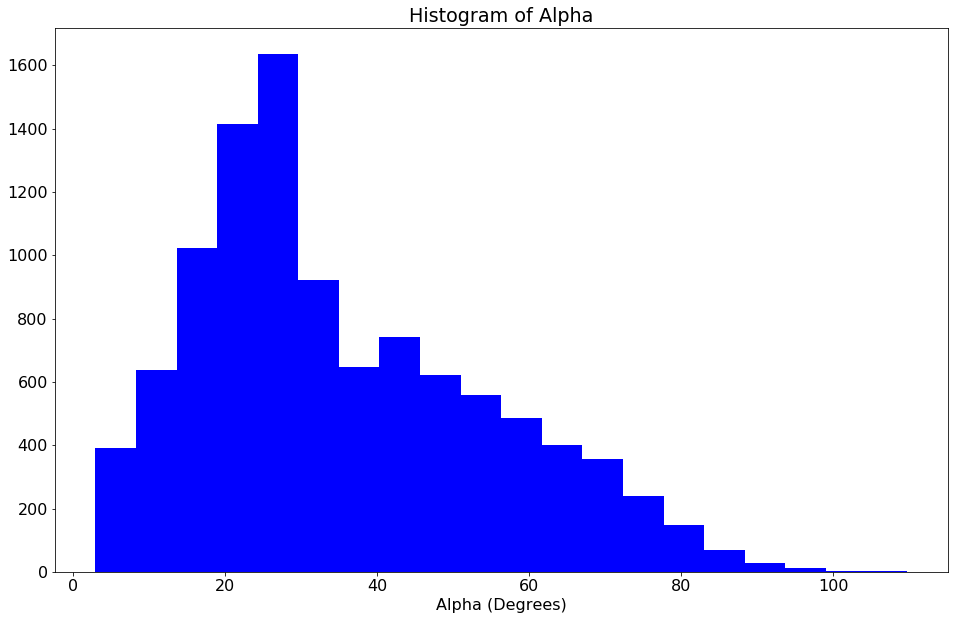

In [27]:
fig, ax = plt.subplots()
ax.set_title('Histogram of Alpha')
ax.set_xlabel('Alpha (Degrees)')
_ = ax.hist(alpha_deg, bins=20, color='blue')
plt.show()

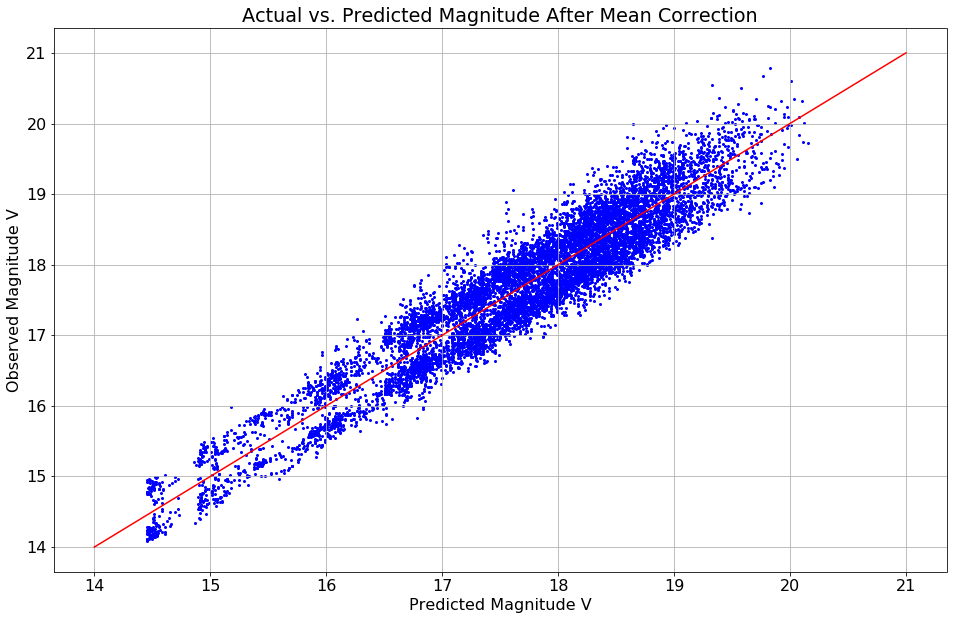

In [28]:
fig, ax = plt.subplots()
ax.set_title('Actual vs. Predicted Magnitude After Mean Correction')
ax.set_xlabel('Predicted Magnitude V')
ax.set_ylabel('Observed Magnitude V')
plt.scatter(ztf_hit.V_pred, ztf_hit.V_obs, color='blue', s=4)
xx = np.linspace(14.0, 21.0, 701)
ax.plot(xx, xx, color='red')
ax.grid()
plt.show()

In [29]:
# Mean error
err = ztf_hit.V_pred - ztf_hit.V_obs
mse = np.mean(err**2)
rmse = np.sqrt(mse)
print(f'Root mean squared error = {rmse:5.4f}')

Root mean squared error = 0.3620


In [30]:
element_ids = elts.element_id.values

In [31]:
element_id = element_ids[1] 
mask = (ztf_hit.element_id == element_id)
df = ztf_hit[mask]

V_obs_elt = df.V_obs.values
V_calc_elt = df.V_calc.values

err = V_obs_elt - V_calc_elt
mean_err = np.mean(err)
rms = np.sqrt(np.mean(err**2))
stdev = np.std(err)
print(f'RMS Error = {rms:5.2f}')
print(f'STDev = {stdev:5.2f}')

RMS Error =  0.66
STDev =  0.36


In [ ]:
fig, ax = plt.subplots()
ax.set_title(f'Actual vs. Predicted Magnitude After Mean Correction')
ax.set_xlabel('Observed Magnitude V')
ax.set_ylabel('Predicted Magnitude V')
plt.scatter(df.V_obs, df.V_calc+mean_err, color='blue', s=4)
ax.plot(df.V_obs, df.V_obs, color='red')
# ax.scatter(df.V_obs, df.H, color='green', s=1)
# ax.scatter(df.V_obs, df.H+ztf_hit.dist_adj, color='orange', s=1)
# ax.scatter(df.V_obs, df.H+df.dist_adj-0.8*df.phase_adj, color='purple', s=1)
ax.grid()
plt.show()

In [ ]:
np.std(V_obs - V_pred)